# PS5

In [1]:
"""
Author: Chittaranjan
"""

'\nAuthor: Chittaranjan\n'

In [2]:
from os.path import exists
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

from intervals import calc_agresti_coull

## Q0 - R-Squared Warmup

#### Read in the data, perform log transformation, and fit a model

In [3]:
# tooth growth data
file = 'tooth_growth.pickle'
if exists(file):
    tg_data = pd.read_pickle(file)
else:
    tooth_growth = sm.datasets.get_rdataset('ToothGrowth')
    tg_data = tooth_growth.data
    tg_data.to_pickle(file)

In [4]:
tg_data["dose"] = tg_data["dose"].astype("category")
# log transform
tg_data["log_len"] = np.log(tg_data["len"])

In [5]:
tg_mod = smf.ols('log_len ~ supp*dose', data=tg_data)
tg_fit = tg_mod.fit()
tg_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_len   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     41.69
Date:                Fri, 05 Nov 2021   Prob (F-statistic):           2.34e-17
Time:                        14:49:39   Log-Likelihood:                 4.2612
No. Observations:                  60   AIC:                             3.478
Df Residuals:                      54   BIC:                             16.04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  2.5326      0.075     33.711      0.000       2.382       2.683
supp[T.VC]                -0.5118      0.106     -4.817      0.000      -0.725      -0.299
dose[T.1.0]                0.5745      0.106      5.407      0.000       0.362       0.788
dose[T.2.0]                0.7232      0.106      6.807      0.000       0.510       0.936
supp[T.VC]:dose[T.1.0]     0.2148      0.150      1.430      0.159      -0.086       0.516
supp[T.VC]:dose[T.2.0]     0.5041      0.150      3.355      0.001       0.203       0.805
==============================================================================
Omnibus:                        0.136   Durbin-Watson:                   1.862
Prob(Omnibus):                  0.934   Jarque-Bera (JB):                0.039
Skew:                          -0.058   Prob(JB):                        0.981
Kurtosis:                       2.953   Cond. No.                         9.77
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Compute $R^2$

In [6]:
rsquared = 1 - (tg_fit.ssr / tg_fit.centered_tss)
rsquared

0.7942457970936073

In [7]:
assert rsquared == tg_fit.rsquared

#### Compute Adjusted $R^2$

In [8]:
c = (tg_fit.nobs - 1) / (tg_fit.nobs - len(tg_mod.exog_names))
adj_rsquared = 1 - ((1 - tg_fit.rsquared) * c)
adj_rsquared

0.7751944820096821

In [9]:
assert adj_rsquared == tg_fit.rsquared_adj

## Q1 - NHANES Dentition

In [10]:
TOOTH_NUM_MAP = {
    1: "3rd molar (wisdom tooth)",
    2: "2nd molar (12-yr molar)",
    3: "1st molar (6-yr molar)",
    4: "2nd bicuspid (2nd premolar)",
    5: "1st bicuspid (1st premolar)",
    6: "Cuspid (canine/eye tooth)",
    7: "Lateral incisor",
    8: "Central incisor",
    9: "Central incisor",
    10: "Lateral incisor",
    11: "Cuspid (canine/eye tooth)",
    12: "1st bicuspid (1st premolar)",
    13: "2nd bicuspid (2nd premolar)",
    14: "1st molar (6-yr molar)",
    15: "2nd molar (12-yr molar)",
    16: "3rd molar (wisdom tooth)",
    17: "3rd molar (wisdom tooth)",
    18: "2nd molar (12-yr molar)",
    19: "1st molar (6-yr molar)",
    20: "2nd bicuspid (2nd premolar)",
    21: "1st bicuspid (1st premolar)",
    22: "Cuspid (canine/eye tooth)",
    23: "Lateral incisor",
    24: "Central incisor",
    25: "Central incisor",
    26: "Lateral incisor",
    27: "Cuspid (canine/eye tooth)",
    28: "1st bicuspid (1st premolar)",
    29: "2nd bicuspid (2nd premolar)",
    30: "1st molar (6-yr molar)",
    31: "2nd molar (12-yr molar)",
    32: "3rd molar (wisdom tooth)"
}

### Part (a)

#### Read in data and discard rows with age < 12

In [11]:
DEMOGRAPHICS_PKL = "demographics.pickle"
DENTITION_PKL = "dentition.pickle"
assert exists(DEMOGRAPHICS_PKL)
assert exists(DENTITION_PKL)

In [12]:
demo_df = pd.read_pickle(DEMOGRAPHICS_PKL)
dent_df = pd.read_pickle(DENTITION_PKL)

In [13]:
teeth_cols = [f"tooth_count_{str(i).rjust(2, '0')}" for i in range(1, 33)]
dataset = demo_df.merge(dent_df, on="id", how="left")[teeth_cols + ["age"]]
dataset = dataset[dataset["age"] > 12]
dataset.shape

(27148, 33)

In [14]:
for col in teeth_cols:
    dataset[col] = np.where(dataset[col] == "Permanent tooth present", 1, 0)

#### Use a function which can be tweaked to generate different knots based on the mean probabilities

__Summary of Procedure Followed__:
- The `generate_knots` function is used to identify knot points based on a
heuristic of number of "peaks" within an age range.
    - A peak is an age at which the probability of the tooth being present
spikes up.
- Different models are tried based on variations of age ranges and number
of peaks to identify per range
- Each candidate model is fitted to `tooth_count_01` and the model with
lowest AIC is picked
- This selected model is then fit to all other teeth and used for
prediction/fitting

In [15]:
def generate_knots(means, age_ranges, knots_per_range):
    """
    Generates a list of knot points for B-splines by identifying peaks

    Parameters
    ----------
    means : pd.Series
        Sequences of values representing the mean probabilities grouped by age.
    age_ranges : list
        List of tuples indicating start and end for age ranges. These are used
        to find knots within each of these ranges
    knots_per_range : int
        The number of peaks to find within each age range.

    Returns
    -------
    list
        Sorted list of knot points (representing ages).

    """
    knots = set()
    for age_lwr, age_upr in age_ranges:
        subset = means[(means.index > age_lwr) & (means.index < age_upr)]
        k = list(subset.nlargest(knots_per_range).index)
        knots.update(k)
    return sorted(list(knots))

In [16]:
avg = dataset.groupby("age")["tooth_count_01"].mean()
knots_option_1 = generate_knots(
    avg,
    [(15, 25), (26, 50), (51, 81)],
    knots_per_range=4
)
knots_option_2 = generate_knots(
    avg,
    [(15, 30), (31, 45), (46, 60), (61, 81)],
    knots_per_range=3
)
knots_option_3 = generate_knots(
    avg,
    [(15, 40), (41, 81)],
    knots_per_range=6
)

In [17]:
knots_option_1, knots_option_2, knots_option_3

([20, 22, 23, 24, 27, 30, 32, 33, 52, 53, 54, 56],
 [23, 24, 26, 32, 33, 37, 49, 50, 52, 62, 63, 65],
 [22, 23, 24, 26, 27, 33, 42, 43, 44, 45, 50, 52])

#### Build models with each of the options for the knot points

In [18]:
def build_model(response, knots, data):
    """
    Builds SMF Logit model with provided data

    Parameters
    ----------
    response : str
        Response variable for which to fit the data.
    knots : list
        List of knot points to use in the B-Splines.
    data : pd.DataFrame
        Data against which to fit the model.

    Returns
    -------
    object
        SMF Model object which has been built with the information provided.

    """
    return smf.logit(
        f"{response} ~ bs(age, knots={knots}, degree=3)", data=data
    )

In [19]:
candidate_models = []
for knots in [knots_option_1, knots_option_2, knots_option_3]:
    mod = build_model("tooth_count_01", knots, dataset)
    candidate_models.append(mod)

#### Select and visualize model that minimizes AIC

In [20]:
def select_model(candidate_models):
    """
    Compares a list of candidate models and picks the one with lowest AIC

    Parameters
    ----------
    candidate_models : list
        List of models which need to be compared.

    Returns
    -------
    model : object
        The model amongst the candidates with best AIC.
    fit : object
        The resulting fit from the selected model.

    """
    model, fit = None, None
    aic = float("inf")
    for mod in candidate_models:
        res = mod.fit()
        aic, model, fit = ((res.aic, mod, res) if res.aic < aic
                           else (aic, model, fit))
    return model, fit

In [21]:
selected_model, selected_model_fit = select_model(candidate_models)

Optimization terminated successfully.
         Current function value: 0.448153
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.448019
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.448128
         Iterations 9


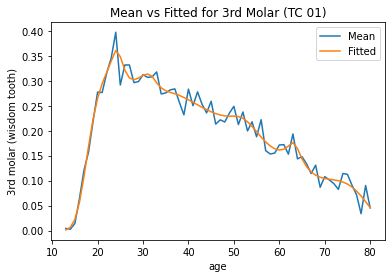

In [22]:
dataset["tooth_count_01_hat"] = (selected_model
                                 .predict(
                                     params=selected_model_fit.params)
                                 )
_ = (dataset
     .groupby("age")[["tooth_count_01", "tooth_count_01_hat"]]
     .mean()
     .plot(
         ylabel=TOOTH_NUM_MAP[1],
         title="Mean vs Fitted for 3rd Molar (TC 01)"
     )
     .legend(["Mean", "Fitted"])
     )

In [23]:
selected_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         tooth_count_01   No. Observations:                27148
Model:                          Logit   Df Residuals:                    27132
Method:                           MLE   Df Model:                           15
Date:                Fri, 05 Nov 2021   Pseudo R-squ.:                 0.07643
Time:                        14:49:40   Log-Likelihood:                -12163.
converged:                       True   LL-Null:                       -13169.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================================================================================
                                                                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                        -6.5599      0.458    -14.313      0.000      -7.458      -5.662
bs(age, knots=[23, 24, 26, 32, 33, 37, 49, 50, 52, 62, 63, 65], degree=3)[0]      5.7559      0.802      7.181      0.000       4.185       7.327
bs(age, knots=[23, 24, 26, 32, 33, 37, 49, 50, 52, 62, 63, 65], degree=3)[1]      5.4821      0.391     14.019      0.000       4.716       6.249
bs(age, knots=[23, 24, 26, 32, 33, 37, 49, 50, 52, 62, 63, 65], degree=3)[2]      6.0669      0.497     12.213      0.000       5.093       7.041
bs(age, knots=[23, 24, 26, 32, 33, 37, 49, 50, 52, 62, 63, 65], degree=3)[3]      5.5137      0.466     11.841      0.000       4.601       6.426
bs(age, knots=[23, 24, 26, 32, 33, 37, 49, 50, 52, 62, 63, 65], degree=3)[4]      5.8892      0.488     12.072      0.000       4.933       6.845
bs(age, knots=[23, 24, 26, 32, 33, 37, 49, 50, 52, 62, 63, 65], degree=3)[5]      5.6119      0.466     12.052      0.000       4.699       6.525
bs(age, knots=[23, 24, 26, 32, 33, 37, 49, 50, 52, 62, 63, 65], degree=3)[6]      5.5867      0.491     11.372      0.000       4.624       6.550
bs(age, knots=[23, 24, 26, 32, 33, 37, 49, 50, 52, 62, 63, 65], degree=3)[7]      5.3315      0.481     11.089      0.000       4.389       6.274
bs(age, knots=[23, 24, 26, 32, 33, 37, 49, 50, 52, 62, 63, 65], degree=3)[8]      5.3488      0.469     11.416      0.000       4.431       6.267
bs(age, knots=[23, 24, 26, 32, 33, 37, 49, 50, 52, 62, 63, 65], degree=3)[9]      5.3184      0.493     10.783      0.000       4.352       6.285
bs(age, knots=[23, 24, 26, 32, 33, 37, 49, 50, 52, 62, 63, 65], degree=3)[10]     4.7011      0.492      9.550      0.000       3.736       5.666
bs(age, knots=[23, 24, 26, 32, 33, 37, 49, 50, 52, 62, 63, 65], degree=3)[11]     5.0779      0.470     10.814      0.000       4.158       5.998
bs(age, knots=[23, 24, 26, 32, 33, 37, 49, 50, 52, 62, 63, 65], degree=3)[12]     3.8812      0.529      7.341      0.000       2.845       4.917
bs(age, knots=[23, 24, 26, 32, 33, 37, 49, 50, 52, 62, 63, 65], degree=3)[13]     4.8894      0.546      8.955      0.000       3.819       5.960
bs(age, knots=[23, 24, 26, 32, 33, 37, 49, 50, 52, 62, 63, 65], degree=3)[14]     3.5289      0.473      7.464      0.000       2.602       4.456
=================================================================================================================================================
"""

In [24]:
selected_model_fit.aic

24357.651906976407

### Part (b)

#### Fit the selected model for all teeth

In [25]:
for tooth_col in teeth_cols:
    avg = dataset.groupby("age")[tooth_col].mean()
    model = build_model(
        tooth_col,
        # manually plugged in after analyzing results from (a)
        generate_knots(
            avg,
            [(15, 30), (31, 45), (46, 60), (61, 81)],
            knots_per_range=3
        ),
        dataset
    )
    fit = model.fit(disp=0)
    dataset[str(tooth_col + "_hat")] = model.predict(params=fit.params)

#### Visualize model for each tooth

In [26]:
def confidence_band(yhats, col, confidence_level=95):
    """
    Use the Agresti-Coull method to generate confidence bands for each fitted
    value

    Parameters
    ----------
    yhats : pd.DataFrame
        DataFrame containing the columns with the y_hat values.
    col : str
        Column name for which the band has to be generated.
    confidence_level : float, optional
        Confidence level at which the band is desired. The default is 95.

    Returns
    -------
    str
        Comma separated lower and upper level of confidence bounds.

    """
    statistic = calc_agresti_coull(yhats[col], confidence_level)
    return ",".join([str(statistic["lwr"]), str(statistic["upr"])])

In [27]:
def visualize_mean_vs_fitted(dataset):
    """
    Plots mean vs fitted values along with confidence region for every tooth

    Parameters
    ----------
    dataset : pd.DataFrame
        Entire dataset with fitted and mean values.

    Returns
    -------
    None.

    """
    fig, axes = plt.subplots(nrows=8, ncols=4, sharex=True, figsize=(20, 25))
    fig.suptitle("Mean vs Fitted for all teeth", fontsize=24)
    fig.tight_layout()
    plt.subplots_adjust(top=0.95)
    for r in range(8):
        for c in range(4):
            tooth_num = ((4 * r) + c) + 1
            tooth_col = "tooth_count_" + str(tooth_num).rjust(2, "0")
            groups = dataset.groupby("age")[[tooth_col, tooth_col + "_hat"]]
            means = groups.mean()
            bands = (
                groups.apply(
                    lambda x: confidence_band(x, tooth_col + "_hat")
                )
                .str
                .split(",", expand=True)
                .astype(float)
            )
            _ = (means
                 .plot(ax=axes[r, c])
                 .fill_between(
                     bands.index,
                     bands[0],
                     bands[1],
                     color="r",
                     alpha=0.1
                 )
                 )
            axes[r, c].set_ylabel(f"{TOOTH_NUM_MAP[tooth_num]}")
            axes[r, c].legend(["Mean", "Fitted"])

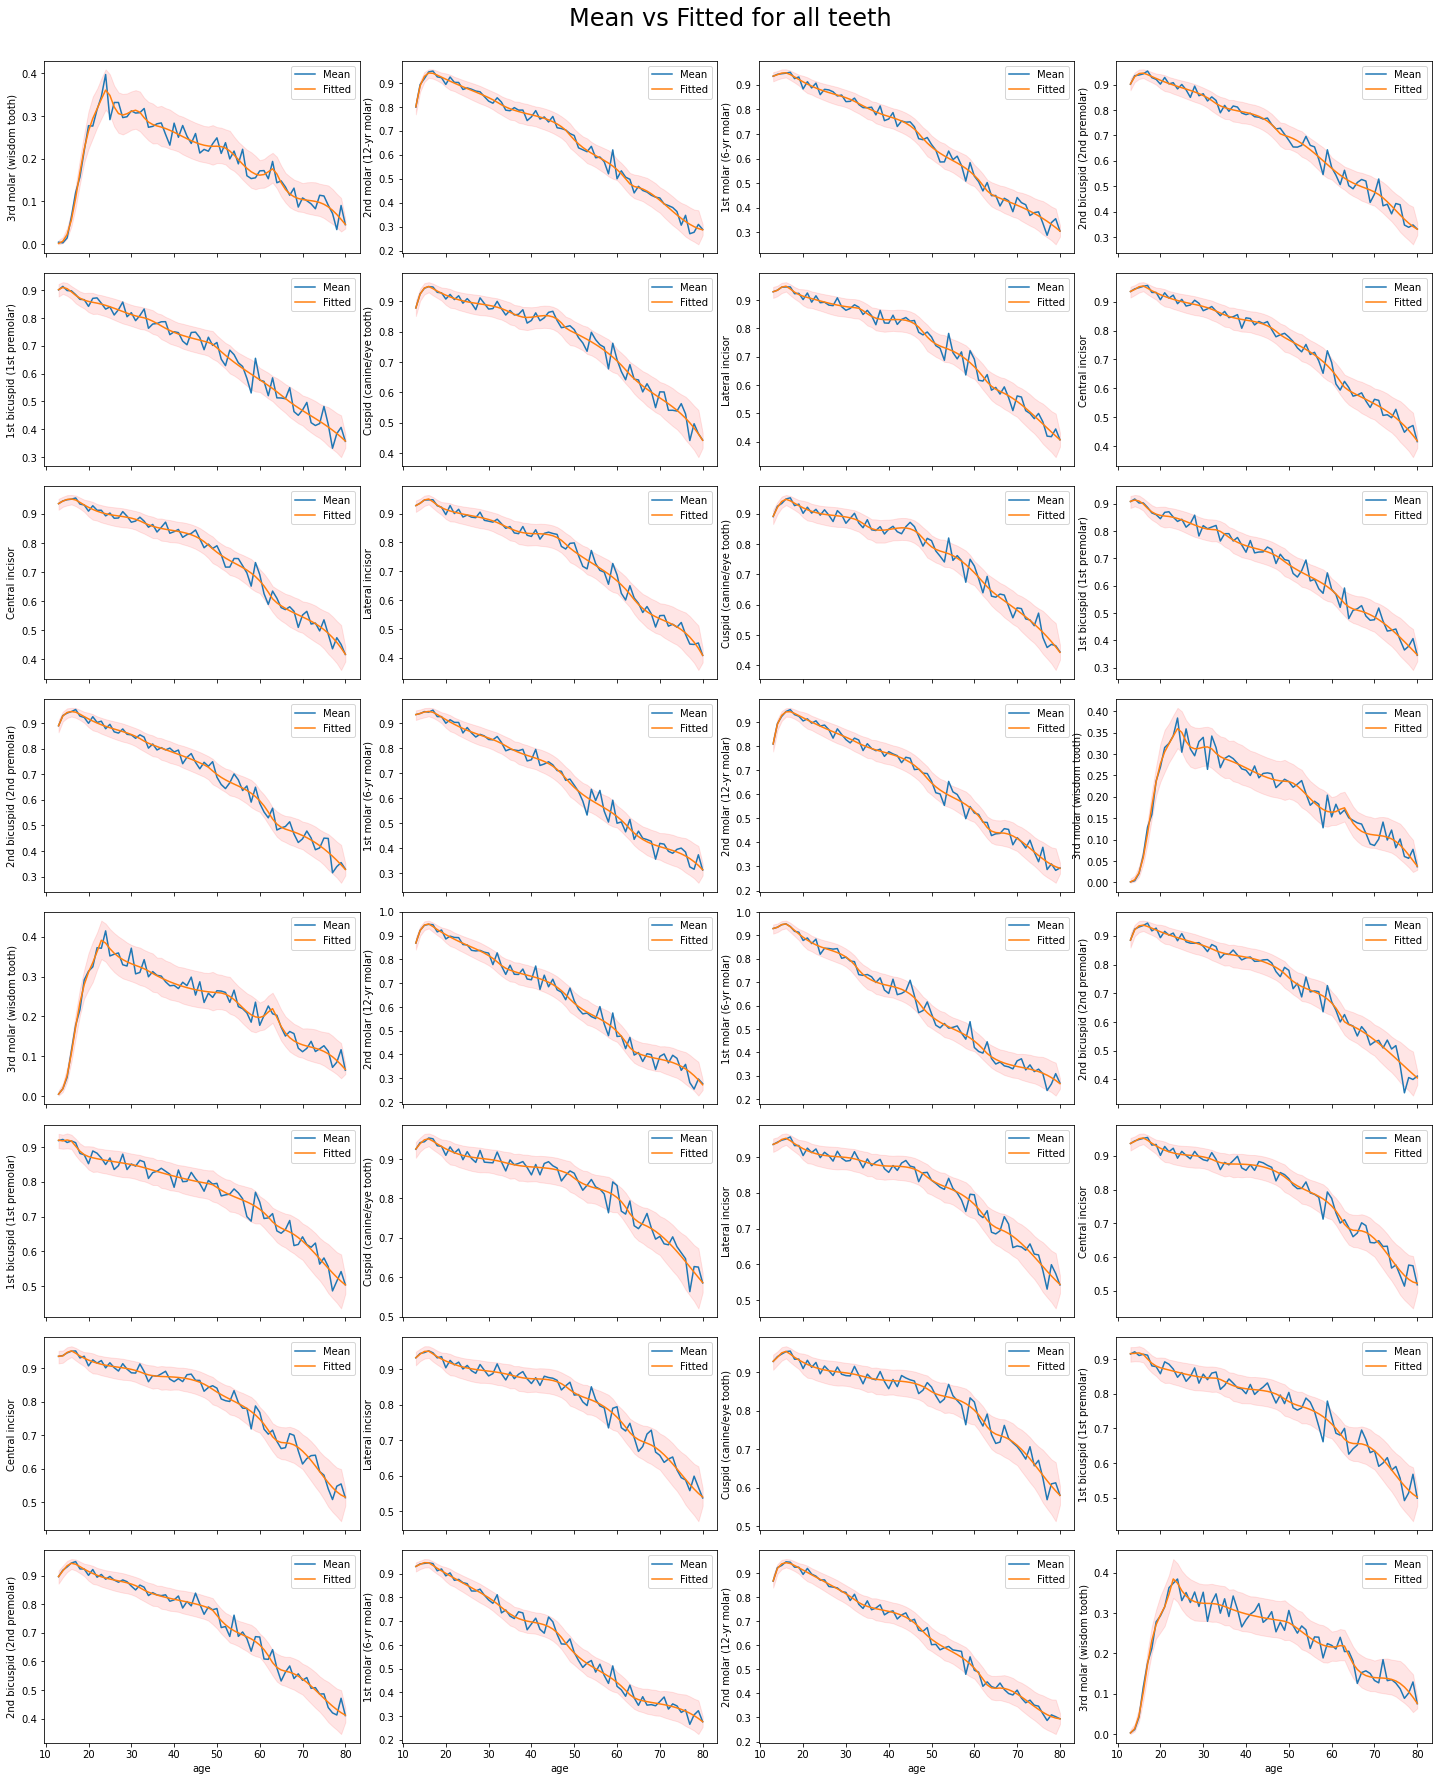

In [28]:
visualize_mean_vs_fitted(dataset)

## Q2 - Hosmer-Lemeshow Calibration

In [29]:
def visualize_calibration(dataset):
    """
    Visualize Hosmer-Lemeshow calibration by plotting expected and observed 
    means for each decile

    Parameters
    ----------
    dataset : pd.DataFrame
        Entire dataset with fitted and mean values.

    Returns
    -------
    None.

    """
    fig_calib, axes_calib = plt.subplots(nrows=8, ncols=4, figsize=(20, 25))
    fig_calib.suptitle("Hosmer-Lemeshow Calibration Plots", fontsize=24)
    fig_calib.tight_layout()
    plt.subplots_adjust(top=0.95)
    for r in range(8):
        for c in range(4):
            tooth_num = ((4 * r) + c) + 1
            tooth_col = "tooth_count_" + str(tooth_num).rjust(2, "0")
            tooth_col_hat = tooth_col + "_hat"
            dataset["deciles"] = pd.qcut(dataset[tooth_col_hat], 10).cat.codes
            (dataset
             .groupby("deciles")[[tooth_col, tooth_col_hat]]
             .mean()
             .plot
             .scatter(
                 x=tooth_col,
                 y=tooth_col_hat,
                 ax=axes_calib[r, c]
             )
             .axline((0, 0), slope=1))
            axes_calib[r, c].set_ylabel(
                f"Predicted probability - {str(tooth_num)}"
            )
            axes_calib[r, c].set_xlabel(
                f"Mean probability - {str(tooth_num)}"
            )

The Hosmer-Lemeshow calibration plots below indicate that the model is
well calibrated, as the observed and expected mean probabilities per
decile lie tightly on the $y=x$ line for all of the 32 models.

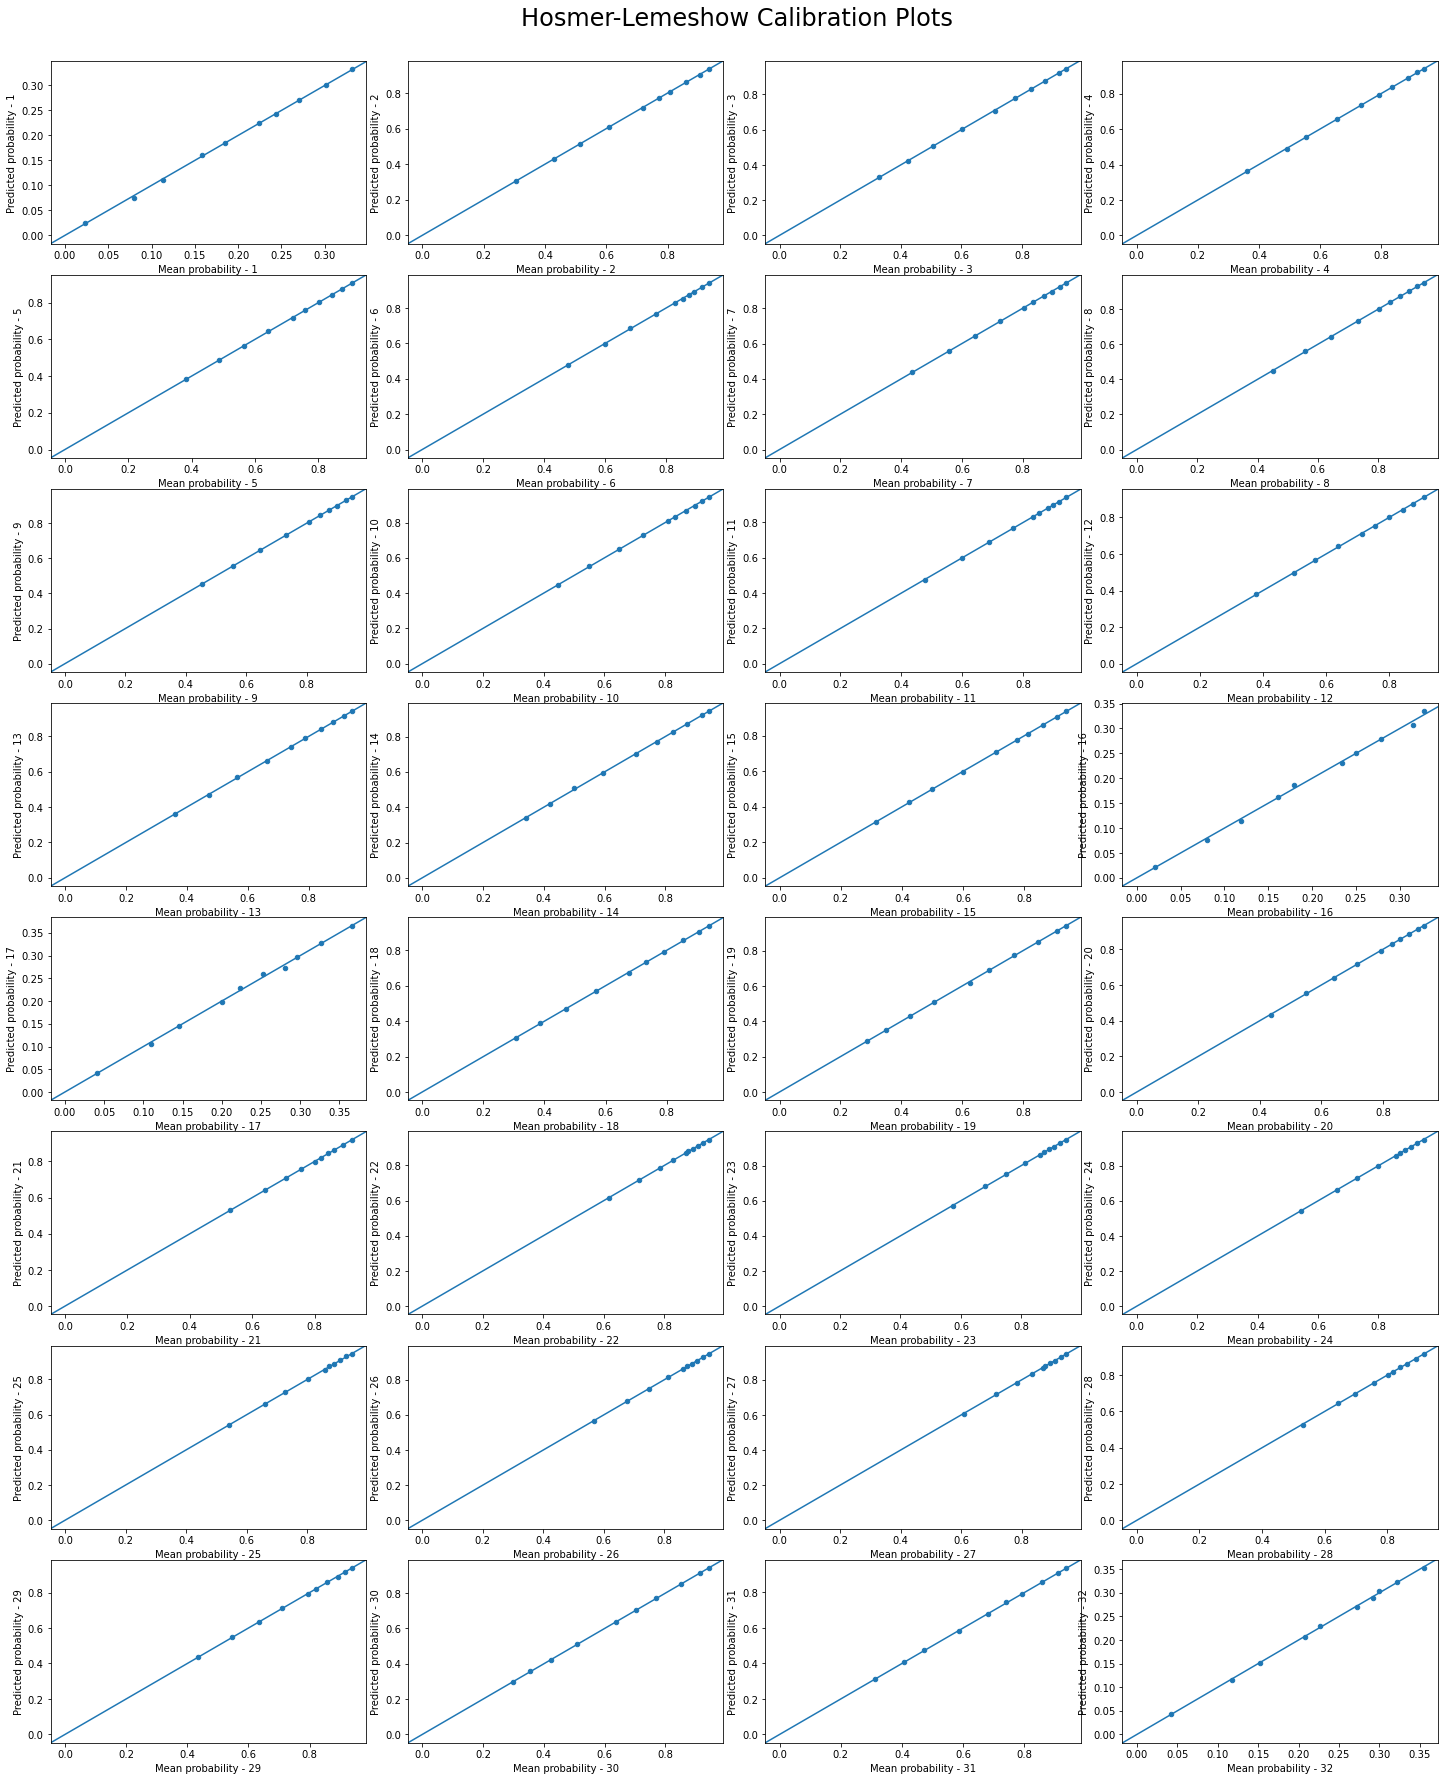

In [30]:
visualize_calibration(dataset)